# binary classification example - titanic dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%load_ext autoreload
%autoreload 2

In [43]:
import copy
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from pandas.testing import assert_series_equal
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import treelite
import treelite_runtime
import dill
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import seaborn as sns
cmap = sns.color_palette("viridis", as_cmap=True)
# cmap = sns.color_palette("vlag", as_cmap=True)


**Gators** imports

In [5]:
from gators.util import util
# data cleaning
from gators.data_cleaning import (
    ConvertColumnDatatype,
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
    Replace,
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    OrdinalEncoder, 
    WOEEncoder,
    TargetEncoder,
    OneHotEncoder,
    
)
# binning
from gators.binning import (
    BinRareCategories,
    BinSingleTargetClassCategories,
    Binning,
    CustomBinning,
    QuantileBinning,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    PolynomialFeatures,
    ElementaryArithmetics,
    PolynomialObjectFeatures,
    IsNull,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
# feature selection
from gators.feature_selection import (
    SelectFromModel,
    InformationValue
)
# model building
from gators.model_building import (
    TrainTestSplit,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

**Pipeline composed of the following transformations**
* String features
* Imputers
* Binning
* Polynomial Features
* Encoder

### with pandas

In [6]:
data = pd.read_parquet('data/titanic.parquet')
data = data.reset_index(drop=True)
y = data['Survived']
X = data.drop('Survived', axis=1)
train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

In [7]:
X_train.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### data analysis

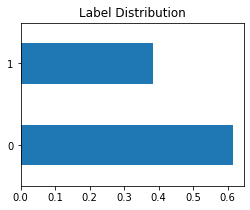

In [8]:
label_counts = data['Survived'].value_counts(normalize=True).sort_values().iloc[::-1]
label_counts.plot(
    kind='barh', 
    figsize=(4, 3), 
    title='Label Distribution',
);

In [52]:
steps = [
    ('StringLength', StringLength(columns=['Ticket'])),
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('IsNull', IsNull(columns=['Age', 'Cabin'])),
    ('DropColumns', DropColumns(['Name',  'Dummy', 'Cabin', 'Ticket'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=120),
        inplace=True)),
    ('Encoder', WOEEncoder()),
]
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)
pipe.display_encoder_mapping_nb(cmap=cmap)

,woe values
Title,
Don|Dr|Rev|Mr,-1.673433
Major,0.000000
Master,0.071459
Miss,0.898856
Mrs|Lady|Mme|Ms|Sir,1.406362


,woe values
Sex,
male,-1.472597
female,1.087151


,woe values
Fare,
"(-inf, 10.48125]",-1.290241
"(10.48125, 19.73335]",-0.113023
"(19.73335, 40.8521]",-0.329479
"(40.8521, inf)",0.532566


,woe values
Pclass,
"(-inf, 1.5]",0.402706
"(1.5, 2.5]",0.061088
"(2.5, inf)",-1.048984


,woe values
Cabin__is_null,
"(-inf, 0.5]",0.614366
"(0.5, inf)",-0.750931


,woe values
FamilySize,
"(-inf, 0.5]",-0.761568
"(0.5, 1.5]",0.066140
"(1.5, inf)",-0.042864


,woe values
Embarked,
S,-0.628394
Q,-0.140582
C|MISSING,0.130265


,woe values
Ticket__length,
"(-inf, 5.5]",0.012987
"(5.5, 7.5]",-0.629521
"(7.5, inf)",-0.477209


,woe values
Parch,
"(-inf, 0.5]",-0.583214
"(0.5, inf)",0.040005


,woe values
SibSp,
"(-inf, 0.5]",-0.592266
"(0.5, inf)",-0.114959


,woe values
Age,
"(-inf, 25.5]",-0.263653
"(25.5, 30.5]",-0.725008
"(30.5, inf)",-0.300314


,woe values
Age__is_null,
"(-inf, 0.5]",-0.339249
"(0.5, inf)",-0.779656


### data with polynomial object columns

In [51]:
steps = [
    ('StringLength', StringLength(columns=['Ticket'])),
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('IsNull', IsNull(columns=['Age', 'Cabin'])),
    ('DropColumns', DropColumns(['Name',  'Dummy', 'Cabin', 'Ticket'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=120),
        inplace=True)),
    ('Replace', Replace(
        to_replace_dict={
            'Fare': {
                '_0': 'EconomicFare', 
                '_1': 'EconomicPlusFare', 
                '_2': 'BussinessFare', 
                '_3': 'FirstClassFare',},
            'Pclass': {'_0': '1stClass', '_1': '2ndClass', '_2': '3rdClass'},
            'Sex': {'female': 'Woman', 'male': 'Man'}
        }
    )),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize'],
        degree=2)),
    ('CleanCategories', BinRareCategories(min_ratio=0.)),
    ('Encoder', WOEEncoder()),
]
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)
pipe.display_encoder_mapping_nb(cmap=cmap)

,woe values
Pclass__Title,
2ndClassDon|Dr|Rev|Mr,-2.071073
3rdClassDon|Dr|Rev|Mr,-1.940702
1stClassDon|Dr|Rev|Mr,-0.877240
3rdClassMaster,-0.730888
1stClassMajor,0.000000
3rdClassMrs|Lady|Mme|Ms|Sir,0.062520
3rdClassMiss,0.103990
1stClassMaster,1.609438
2ndClassMiss,2.322388


,woe values
Fare__Title,
EconomicFareDon|Dr|Rev|Mr,-1.970990
EconomicPlusFareDon|Dr|Rev|Mr,-1.801516
BussinessFareDon|Dr|Rev|Mr,-1.310945
FirstClassFareDon|Dr|Rev|Mr,-1.098612
FirstClassFareMaster,-0.587787
BussinessFareMaster,-0.236389
BussinessFareMajor,0.000000
EconomicFareMrs|Lady|Mme|Ms|Sir,0.000000
EconomicFareMiss,0.268264


,woe values
Pclass__Sex,
3rdClassMan,-1.809023
2ndClassMan,-1.483287
1stClassMan,-0.737599
3rdClassWoman,0.092659
2ndClassWoman,2.494123
1stClassWoman,2.898277


,woe values
Sex__Fare,
ManEconomicFare,-1.970990
ManEconomicPlusFare,-1.338892
ManBussinessFare,-1.055127
ManFirstClassFare,-0.984853
WomanEconomicFare,0.236389
WomanBussinessFare,0.732888
WomanEconomicPlusFare,1.143564
WomanFirstClassFare,2.631089


,woe values
Sex__Embarked,
ManQ,-2.360854
ManS,-1.501015
ManC|MISSING,-1.059772
WomanS,0.759329
WomanQ,1.694596
WomanC|MISSING,1.866661


,woe values
Embarked__Title,
QDon|Dr|Rev|Mr,-2.240710
QMaster,-1.945910
SDon|Dr|Rev|Mr,-1.727489
C|MISSINGDon|Dr|Rev|Mr,-1.247825
SMajor,0.000000
SMaster,0.174353
SMiss,0.479573
QMrs|Lady|Mme|Ms|Sir,1.098612
SMrs|Lady|Mme|Ms|Sir,1.161133


,woe values
Title__FamilySize,
Don|Dr|Rev|Mr_1,-1.677646
Don|Dr|Rev|Mr_0,-1.658775
Don|Dr|Rev|Mr_2,-1.639743
Major_0,0.000000
Master_2,0.000000
Miss_2,0.546544
Mrs|Lady|Mme|Ms|Sir_2,0.816761
Miss_1,0.969401
Miss_0,1.081370


,woe values
Age__Title,
_1Don|Dr|Rev|Mr,-1.821235
_0Don|Dr|Rev|Mr,-1.714109
_2Don|Dr|Rev|Mr,-1.469472
_1Master,-0.510826
_2Major,0.000000
_0Master,0.160343
_0Miss,0.703729
_1Mrs|Lady|Mme|Ms|Sir,0.769133
_1Miss,0.858662


,woe values
Sex__Age,
Man_1,-1.787686
Man_2,-1.400346
Man_0,-1.202153
Woman_1,0.833920
Woman_0,0.896488
Woman_2,1.609438


,woe values
Title,
Don|Dr|Rev|Mr,-1.673433
Major,0.000000
Master,0.071459
Miss,0.898856
Mrs|Lady|Mme|Ms|Sir,1.406362


,woe values
Sex__Title,
ManDon|Dr|Rev|Mr,-1.673433
ManMajor,0.000000
ManMaster,0.071459
WomanMiss,0.898856
ManMrs|Lady|Mme|Ms|Sir,1.098612
WomanMrs|Lady|Mme|Ms|Sir,1.393028


,woe values
Sex__FamilySize,
Man_0,-1.640414
Man_1,-1.466337
Man_2,-0.869038
Woman_2,0.663294
Woman_0,1.263162
Woman_1,1.358123


,woe values
Pclass__Fare,
2ndClassEconomicFare,-2.197225
3rdClassFirstClassFare,-1.335001
3rdClassEconomicFare,-1.262615
3rdClassBussinessFare,-1.124930
1stClassEconomicFare,-1.098612
1stClassBussinessFare,-0.359374
3rdClassEconomicPlusFare,-0.179048
2ndClassEconomicPlusFare,-0.057987
2ndClassFirstClassFare,0.000000


,woe values
Pclass__Embarked,
3rdClassS,-1.358689
3rdClassC|MISSING,-0.614366
3rdClassQ,-0.227390
1stClassQ,0.000000
2ndClassC|MISSING,0.000000
2ndClassS,0.034191
1stClassS,0.188794
1stClassC|MISSING,0.704708
2ndClassQ,1.609438


,woe values
Fare__Embarked,
EconomicFareS,-1.602396
EconomicFareC|MISSING,-1.315677
BussinessFareC|MISSING,-0.659246
BussinessFareS,-0.270546
BussinessFareQ,-0.251314
EconomicFareQ,-0.251314
EconomicPlusFareS,-0.196280
EconomicPlusFareC|MISSING,0.000000
FirstClassFareQ,0.000000


,woe values
Age__Fare,
_2EconomicFare,-1.686399
_1EconomicFare,-1.201930
_0EconomicFare,-1.164752
_2BussinessFare,-0.502629
_1BussinessFare,-0.457833
_1EconomicPlusFare,-0.336472
_2EconomicPlusFare,-0.294800
_1FirstClassFare,-0.071459
_0BussinessFare,0.045462


,woe values
Fare__FamilySize,
EconomicFare_2,-1.734601
EconomicFare_1,-1.435085
EconomicFare_0,-1.248241
BussinessFare_0,-0.479573
EconomicPlusFare_1,-0.392042
BussinessFare_2,-0.291910
EconomicPlusFare_0,-0.291910
BussinessFare_1,-0.138150
FirstClassFare_2,0.264693


,woe values
Sex,
Man,-1.472597
Woman,1.087151


,woe values
Pclass__Age,
3rdClass_2,-1.413693
3rdClass_1,-0.976189
3rdClass_0,-0.940649
2ndClass_1,-0.578078
2ndClass_2,-0.111226
1stClass_1,0.114410
1stClass_2,0.324661
2ndClass_0,0.709148
1stClass_0,0.973449


,woe values
Pclass__FamilySize,
3rdClass_0,-1.185354
3rdClass_1,-0.815037
3rdClass_2,-0.813106
2ndClass_0,-0.377763
1stClass_0,-0.054808
2ndClass_1,0.076961
1stClass_1,0.793952
1stClass_2,0.955511
2ndClass_2,1.183770


,woe values
Embarked__FamilySize,
S_0,-0.976510
Q_2,-0.955511
C|MISSING_0,-0.358634
S_2,-0.180670
S_1,-0.164755
Q_0,-0.097638
C|MISSING_1,0.395313
Q_1,0.451985
C|MISSING_2,1.098612


,woe values
Age__Embarked,
_2Q,-1.299283
_1S,-1.057998
_1C|MISSING,-0.546544
_0S,-0.487413
_2S,-0.444686
_0Q,-0.167054
_1Q,0.050010
_2C|MISSING,0.376478
_0C|MISSING,0.672944


,woe values
Fare,
BussinessFare,-0.329479
EconomicFare,-1.290241
EconomicPlusFare,-0.113023
FirstClassFare,0.532566


,woe values
Pclass,
1stClass,0.402706
2ndClass,0.061088
3rdClass,-1.048984


,woe values
Age__FamilySize,
_0_0,-0.964182
_1_2,-0.955511
_1_0,-0.777147
_2_0,-0.574629
_1_1,-0.296266
_2_2,0.000000
_2_1,0.070204
_0_2,0.225956
_0_1,0.444686


,woe values
Cabin__is_null,
"(-inf, 0.5]",0.614366
"(0.5, inf)",-0.750931


,woe values
FamilySize,
"(-inf, 0.5]",-0.761568
"(0.5, 1.5]",0.066140
"(1.5, inf)",-0.042864


,woe values
Embarked,
S,-0.628394
Q,-0.140582
C|MISSING,0.130265


,woe values
Ticket__length,
"(-inf, 5.5]",0.012987
"(5.5, 7.5]",-0.629521
"(7.5, inf)",-0.477209


,woe values
Parch,
"(-inf, 0.5]",-0.583214
"(0.5, inf)",0.040005


,woe values
SibSp,
"(-inf, 0.5]",-0.592266
"(0.5, inf)",-0.114959


,woe values
Age,
"(-inf, 25.5]",-0.263653
"(25.5, 30.5]",-0.725008
"(30.5, inf)",-0.300314


,woe values
Age__is_null,
"(-inf, 0.5]",-0.339249
"(0.5, inf)",-0.779656


In [ ]:
k = 20
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
offline_steps = [
    ('StringLength', StringLength(columns=['Ticket', 'Cabin'])),
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('DropColumns', DropColumns(['Ticket', 'Name', 'Dummy'])),
    ('BinRareCategories1', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=50),
        inplace=True)),
    ('Replace', Replace(
        to_replace_dict={
            'Fare': {
                '_0': 'EconomicFare', 
                '_1': 'EconomicPlusFare', 
                '_2': 'BussinessFare', 
                '_3': 'BussinessPlusFare',
                '_4': 'FirstClassFare',},
            'Age': {
                '_0': 'Young', '_1': 'Teenager', '_2': 'YoungAdult', '_3': 'Adult', '_4': 'Senior'},
            'Pclass': {'_0': '1stClass', '_1': '2ndClass', '_2': '3rdClass'},
            'FamilySize': {
                '_0': 'NoFamily',
                '_1': 'SmallFamily', 
                '_2': 'NormalFamiy', 
                '_3': 'BigFamily'},
            'Sex': {'female': 'Woman', 'male': 'Man'}
        }
    )),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize'],
        degree=2)),
    ('CleanCategories', BinRareCategories(min_ratio=0.)),
    ('InformationValue', InformationValue(k=k)),
]
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train.copy(), y_train)
features = list(X_train_prepro.columns)

In [ ]:
offline_pipe.steps[-1][1].feature_importances_.iloc[::-1].plot(
    kind='barh', 
    figsize=(7, 5), 
    title='Feature Importance',
);

In [ ]:
base_features = [
    'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [ ]:
steps = [
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('DropColumns', DropColumns(['Name', 'Dummy'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=25),
        inplace=True)),
    ('Replace', Replace(
        to_replace_dict={
            'Fare': {
                '_0': 'CheapFare', 
                '_1': 'NormalFare', 
                '_2': 'ExpensiveFare', 
                '_3': 'ExtremeFare'},
            'Age': {
                '_0': 'Young',
                '_1': 'Young',
                '_2': 'Adult', 
                '_3': 'Senior'},
            'Pclass': {
                '_0': '1stClass', 
                '_1': '2ndClass', 
                '_2': '3rdClass'},
            'FamilySize': {
                '_0': 'NoFamily',
                '_1': 'SmallFamily', 
                '_2': 'NormalFamiy', 
                '_3': 'BigFamily'},
            'Sex': {'female': 'Woman', 'male': 'Man'}
        }
    )),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=[
            'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 
            'Title', 'FamilySize'],
        degree=2)),
    ('LastDropColumns', DropColumns(
        columns=['Sex', 'Age', 'SibSp', 'FamilySize'])),
    ('BinRareCategories2', BinRareCategories(min_ratio=0.)),
    ('Encoder', WOEEncoder(add_missing_categories=True)),
    ('ESTIMATOR', XGBClassifier(random_state=0))
]


param_distributions = {
    "TreeBinning__tree": [
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=25, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=3, 
            min_samples_leaf=25, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=50, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=3, 
            min_samples_leaf=50, 
            random_state=0),
    ],
    'ESTIMATOR__min_child_weight': [5, 10, 20],
    'ESTIMATOR__gamma': [0.25, 0.5, 1],
    'ESTIMATOR__subsample': [0.4, 0.6, 0.8],
    'ESTIMATOR__colsample_bytree': [0.7, 0.8, 0.9],
    'ESTIMATOR__max_depth': [5, 6, 7],
    'ESTIMATOR__min_child_weight': [5, 10, 20],
}
def f1_score(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)
f1_scoring = make_scorer(f1_score)

cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
pipe = Pipeline(steps=steps, verbose=False)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions, 
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    scoring=f1_scoring,
    verbose=True)
_ = search.fit(X_train[base_features].copy(), y_train)

In [ ]:
(search.predict(X_train[base_features].copy()) == y_train).mean(), (search.predict(X_test[base_features].copy()) == y_test).mean()

In [ ]:
(search.predict(X_train[base_features].copy()) == y_train).mean(), (search.predict(X_test[base_features].copy()) == y_test).mean()

In [ ]:
pd.Series(
    search.best_estimator_[-1].feature_importances_,
    index=search.best_estimator_[-2].columns_
).sort_values(ascending=False)

In [ ]:
import copy
prod_pipeline = copy.copy(pipe)
prod_pipeline.steps.pop(-1)

In [ ]:
prod_pipeline.fit(X_train.copy(), y_train)

### with dask

In [ ]:
import dask.dataframe as dd
import dask.distributed
client = dask.distributed.Client()

In [ ]:
data_dd = dd.read_parquet('data/titanic.parquet')
data_dd = data_dd.reset_index(drop=True)
y_dd = data_dd['Survived']
X_dd = data_dd.drop('Survived', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split.transform(X_dd, y_dd)
X_train_dd = client.persist(X_train_dd)
X_test_dd = client.persist(X_test_dd)
y_train_dd = client.persist(y_train_dd)
y_test_dd = client.persist(y_test_dd)

In [ ]:
offline_pipe_dd = Pipeline(steps=offline_steps)
X_train_prepro_dd = offline_pipe_dd.fit_transform(
    X_train_dd, y_train_dd)

In [ ]:
offline_pipe_dd.steps[-1][1].feature_importances_.iloc[::-1].plot(
    kind='barh', 
    figsize=(7, 5), 
    title='Feature Importance',
);

### koalas

In [ ]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set('spark.executor.memory', '2g')
SparkContext(conf=conf)
import databricks.koalas as ks
ks.set_option('compute.default_index_type', 'distributed-sequence')

In [ ]:
data_ks = ks.read_parquet('data/titanic.parquet')
data_ks = data_ks.reset_index(drop=True) # important!
y_ks = data_ks['Survived']
X_ks = data_ks.drop('Survived', axis=1)


train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_ks, X_test_ks, y_train_ks, y_test_ks = train_test_split.transform(X_ks, y_ks)

offline_pipe_ks = Pipeline(steps=offline_steps)
X_train_prepro_ks = offline_pipe_ks.fit_transform(
    X_train_ks, y_train_ks)

#### check pandas, dask, and koalas results match - offline pipeline

In [ ]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prepro_dd.compute()
)
assert_frame_equal(
    X_train_prepro, 
    X_train_prepro_ks.to_pandas()
)

## production pipeline & model 

In [ ]:
steps = [
    ('SplitExtractName', SplitExtract(['Name'], [', '], [1], ['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('DropColumns', DropColumns(['Ticket', 'Name', 'Dummy'])),
    ('BinRareCategories1', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('BinSingleTargetClassCategories', BinSingleTargetClassCategories()),
    ('NumericsImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize'])),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=25),
        inplace=True)),
    ('Replace', Replace(
        to_replace_dict={
            'Fare': {
                '_0': 'CheapFare', 
                '_1': 'NormalFare', 
                '_2': 'ExpensiveFare', 
                '_3': 'ExtremeFare'},
            'Age': {
                '_0': 'Young', '_1': 'Teenager', '_2': 'Adult', '_3': 'Senior'},
            'Pclass': {'_0': '1stClass', '_1': '2ndClass', '_2': '3rdClass'},
            'FamilySize': {
                '_0': 'NoFamily',
                '_1': 'SmallFamily', 
                '_2': 'NormalFamiy', 
                '_3': 'BigFamily'},
            'Sex': {'female': 'Woman', 'male': 'Man'}
        }
    )),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize'],
        degree=2)),
    ('BinRareCategories2', BinRareCategories(min_ratio=0.)),
    ('Encoder', WOEEncoder()),
    ('ESTIMATOR', XGBClassifier(random_state=0))
]


param_distributions = {
    "NumericsImputer__strategy": ["mean", "most_freuquent", "constant"],
    "TreeBinning__tree": [
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=25, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=3, 
            min_samples_leaf=25, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=2, 
            min_samples_leaf=50, 
            random_state=0),
        DecisionTreeClassifier(
            max_depth=3, 
            min_samples_leaf=50, 
            random_state=0),
    ]
}
def f1_score(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)
f1_scoring = make_scorer(f1_score)

cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
pipe = Pipeline(steps=steps, verbose=False)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions, 
    n_iter=10,
    cv=cv,
    n_jobs=-1,
    scoring=f1_scoring,
    verbose=True)
_ = search.fit(X_train.copy(), y_train)

### pandas

In [ ]:
X_train_prod = X_train.copy()
X_train_prod_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro_np = prod_pipe.transform_numpy(
    X_train_prod.to_numpy())

#### check transform and transform numpy match

In [ ]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_np),
    pd.DataFrame(X_train_prod_prepro.to_numpy())
)

### dask

In [ ]:
X_train_prod_dd = X_train_dd.copy()
X_train_prod_dd_np = X_train_prod_dd.compute().to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_dd, y_train_dd)
X_train_prod_prepro_dd = prod_pipe.transform(X_train_prod_dd)
X_train_prod_prepro_dd_np = prod_pipe.transform_numpy(
    X_train_prod_dd.compute().to_numpy())

#### check transform and transform numpy match

In [ ]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_dd_np),
    pd.DataFrame(X_train_prod_prepro_dd.compute().to_numpy())
)

### koalas

In [ ]:
X_train_prod_ks = X_train_ks.copy()
X_train_prod_ks_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_ks, y_train_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_prod_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_prod_ks.to_numpy())

#### check transform and transform numpy match

In [ ]:
X_train_prod_prepro_ks.head()

In [ ]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_ks_np),
    pd.DataFrame(X_train_prod_prepro_ks.to_numpy())
)

#### check pandas, dask, and koalas results match - production pipeline

In [ ]:
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_dd_np)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)

## model building

### numpy

In [ ]:
def f1_score(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)
f1_scoring = make_scorer(f1_score)

y_train_np = y_train.to_numpy()
n_splits = 10
max_evals = 100
kfold = StratifiedKFold(n_splits=n_splits)
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 25),
    'max_depth': hp.quniform('max_depth', 2, 3, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
 }
model = XGBClassifier(
    random_state=0, 
    use_label_encoder=False,
)
hyper = HyperOpt(
    model=model,
    algo=tpe.suggest,
    scoring=f1_scoring,
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

In [ ]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Most important features',
);

In [ ]:
hyper.history.sort_values('loss').head()

In [ ]:
model_np = copy.copy(hyper.model)
model_path = 'models/model_titanic.dill'
with open(model_path, 'wb') as file:
    dill.dump(model_np, file)

### pandas

In [ ]:
model_pd = copy.copy(model_np)
_ = model_pd.fit(X_train_prod_prepro, y_train)

### treelite

In [ ]:
xgb_booster = XGBBoosterBuilder.train(
    model=hyper.model, 
    X_train=X_train_prod_prepro_np, 
    y_train=y_train_np,
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain='gcc', 
    libpath='./models/treelite_xgb_titanic.so', 
    params={'parallel_comp': 4},
    verbose=True
)
model_tl = treelite_runtime.Predictor(
    './models/treelite_xgb_titanic.so', verbose=False)

#### check the models prediction match

In [ ]:
X_test_prod = X_test.copy()
X_test_prod_np = X_test_prod.to_numpy()
y_pred_pd = model_pd.predict_proba(
    prod_pipe.transform(X_test_prod))[:, 1]
y_pred_np = model.predict_proba(
    prod_pipe.transform_numpy(X_test_prod_np.copy()))[:, 1]
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_test_prod_np.copy()
        )
    )
)
assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, y_pred_tl)

## model evaluation

In [ ]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test.copy()
X_test_prod_np = X_test_prod.to_numpy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred):.2f}'

## per-sample bechmarking

### pipeline only

In [ ]:
x = X_test_prod.iloc[[0]]
x_np = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(x_np.copy())

In [ ]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

### pipeline & model

In [ ]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(x_np.copy()))[0]
stats_tl = %timeit -o  model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(x_np.copy())))

In [ ]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

In [ ]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'